#Importing libraries

In [ ]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler


In [ ]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, Embedding, LSTM, Embedding, Input
from tensorflow.keras.models import load_model, Sequential, load_model, save_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
import os

In [ ]:
!pip install livelossplot

In [ ]:
from livelossplot import PlotLossesKeras

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Text cleaning

In [ ]:
dataset_path = "/content/drive/MyDrive/Colab Notebooks/alphabets_28x28.csv"

In [ ]:
chunk = pd.read_csv(dataset_path)

<ipython-input-9-c26d3771dfec>:1: DtypeWarning: Columns (1,2,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk = pd.read_csv(dataset_path)


In [ ]:
def preprocess_data(chunk):

    scaler = MinMaxScaler()

    chunk = chunk.drop(index=chunk[chunk.iloc[:, 0] == 'This'].index)

    features = chunk.iloc[:, 1:].astype('float32')
    labels = chunk.iloc[:, 0].astype('str')

    scaled_features = scaler.fit_transform(features)

    reshaped_features = scaled_features.reshape(scaled_features.shape[0], 28, 28, 1)
    one_hot_labels = pd.get_dummies(labels)

    return reshaped_features, one_hot_labels

In [ ]:
X,y = preprocess_data(chunk)

In [ ]:
X_train, X_test, y_train,y_test = train_test_split(X,y,test_size=0.2)
X_test, X_val, y_test, y_val = train_test_split(X_test,y_test,test_size=0.5)
print("X_train.shape =", X_train.shape, " y_tain.shape =", y_train.shape)
print("X_val.shape = ",X_val.shape," y_val.shape =", y_val.shape)
print("X_test.shape = ",X_test.shape," y_test.shape =", y_test.shape)

X_train.shape = (297112, 28, 28, 1)  y_tain.shape = (297112, 26)
X_val.shape =  (37140, 28, 28, 1)  y_val.shape = (37140, 26)
X_test.shape =  (37139, 28, 28, 1)  y_test.shape = (37139, 26)


# Alphabet recognition

In [ ]:
cnn_model = Sequential([
    Conv2D(32, (5, 5), input_shape=(28, 28, 1), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation='relu'),
    Dropout(0.3),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(26, activation='softmax')
])

cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 12, 12, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 5, 5, 64)          0

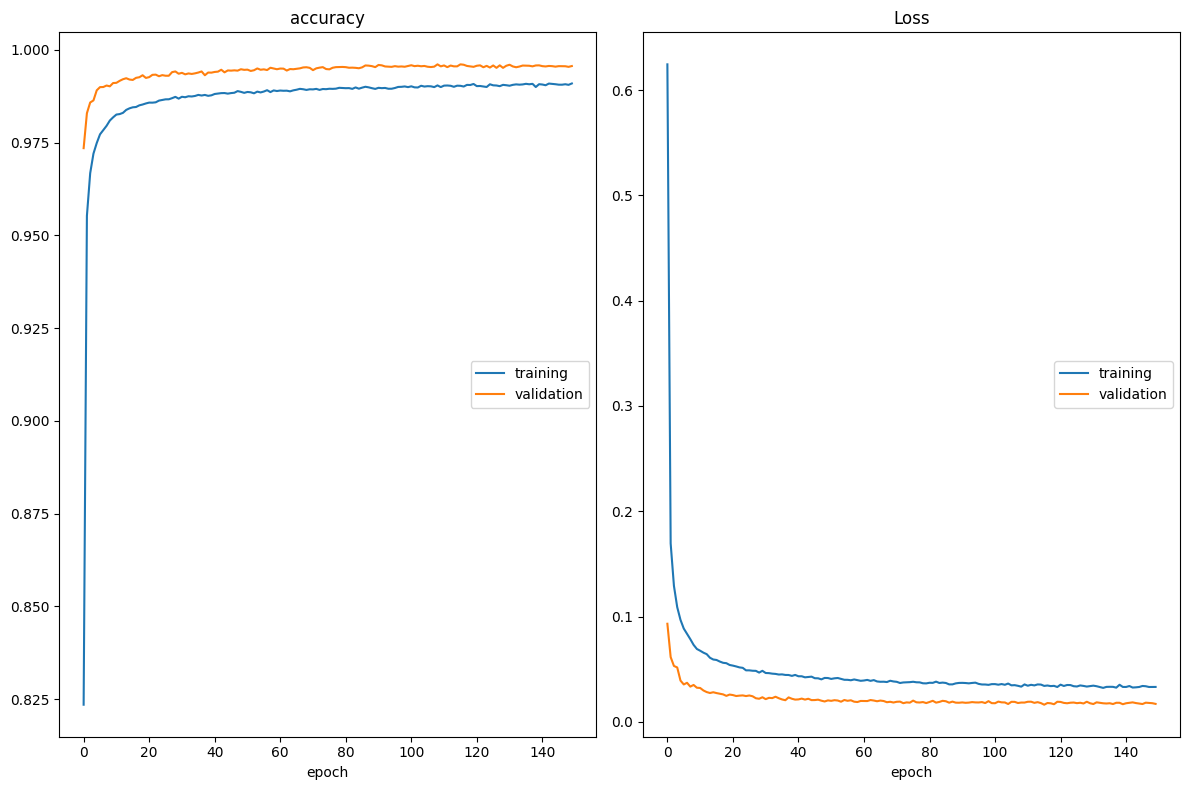

accuracy
	training         	 (min:    0.823, max:    0.991, cur:    0.991)
	validation       	 (min:    0.974, max:    0.996, cur:    0.996)
Loss
	training         	 (min:    0.032, max:    0.624, cur:    0.033)
	validation       	 (min:    0.016, max:    0.093, cur:    0.017)
574/574 [==============================] - 8s 14ms/step - loss: 0.0332 - accuracy: 0.9909 - val_loss: 0.0171 - val_accuracy: 0.9956


In [ ]:
cnn_model.fit(X_train,y_train,epochs=150, batch_size = 518,validation_data=(X_val,y_val), callbacks = [PlotLossesKeras()])

In [ ]:
save_model(cnn_model, '/content/sample_data.h5')

<ipython-input-18-39f71eb22b7d>:1: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(cnn_model, '/content/sample_data.h5')


In [ ]:
cnn_model = load_model('/content/sample_data.h5')


# Predicting from test set and analysing the model

In [ ]:
y_pred_prob = cnn_model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

1161/1161 [==============================] - 3s 2ms/step


In [ ]:
cnn_model.evaluate(X_test,y_test)

1161/1161 [==============================] - 4s 4ms/step - loss: 0.0192 - accuracy: 0.9955


[0.019201021641492844, 0.9955033659934998]

In [ ]:
alpha = {
    0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I',
    9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q',
    17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y',
    25: 'Z'
}

In [ ]:
y_true = y_test.idxmax(axis=1).apply(lambda x: list(alpha.keys())[list(alpha.values()).index(x)])

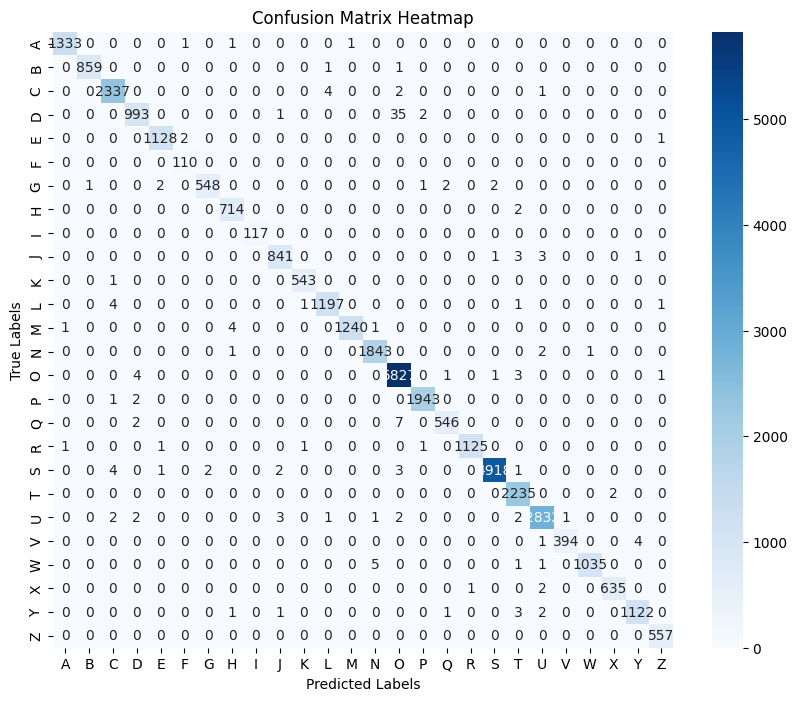

In [ ]:
cm = confusion_matrix(y_true, y_pred)

# Define class names (e.g., A-Z)
class_names = list(alpha.values())

# Plot confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()

*A good observation that words like* \
*C and L* \
*O and D are often missclassified as these are actually hard to classify if written poorly*

# Image segmentation

In [ ]:
def predict(image_path):
  output = ''
  img = load_img(image_path)
  img = img_to_array(img)
  for j in range(0,img.shape[0],28):
    for i in range(0, img.shape[1], 28):
      letter = scaler.fit_transform(img[j:(j+28),i:(i+28),0])
      letter = letter.reshape(1,28,28,1)
      if(letter.sum() == 0):
        if(output[-1]==' '):
          return output[:-1]
        output += " "
      else:
        output += alpha[cnn_model.predict(letter,verbose=0).argmax()]
      #if not model.predict
  return output

In [ ]:
target_labels = pd.read_csv('/content/drive/My Drive/target_labels.csv')

directory_path = '/content/drive/My Drive/target_images'

predictions = {}
scaler = MinMaxScaler()

for image in os.listdir(directory_path):
  image_path = os.path.join(directory_path, image)
  output = predict(image_path)
  predictions[image]= output
  print(image ,": ", output)

line_6.png :  THE MEETING MINUTES YOU PREPARED WERE DETAILED AND WELL ORGANIZED ACCURATELY REFLECTING THE DISCUSSIONS AND DECISIONS MADE
line_4.png :  IT IS WONDERFUL THAT YOU ALWAYS SHOW KINDNESS AND YOUR EMPATHY TOWARDS OTHERS IS TRULY HEARTWARMING AND APPRECIATED
line_1.png :  I AM REALLY ANNOYED BY YOUR CONSTANT COMPLAINING AND YOU NEVER OFFER ANY SOLUTIONS WHICH IS VERY UNHELPFUL AND NEGATIVE 
line_2.png :  IT IS FRUSTRATING THAT YOU NEVER PAY ATTENTION DURING DISCUSSIONS AND YOUR LACK OF FOCUS IS REALLY AFFECTING OUR PROGRESS
line_3.png :  I AM DELIGHTED BY YOUR FRIENDLINESS AND YOU ALWAYS MAKE EVERYONE FEEL WELCOME WHICH FOSTERS A SENSE OF COMMUNITY
line_5.png :  YOUR ANALYSIS OF THE DATA WAS ACCURATE AND WELL PRESENTED PROVIDING A CLEAR UNDERSTANDING OF THE TRENDS AND PATTERNS


In [ ]:
true_labels = [2,1,0,0,1,2]

# Sentiment analysis using Stacked Lstms

In [ ]:
sentiment_dataset = pd.read_csv('/content/sentiment_analysis_dataset.csv')
sentiment_dataset.head()

,line,sentiment
0,I AM REALLY FRUSTRATED BECAUSE YOU CONSTANTLY ...,Angry
1,IT MAKES ME UPSET THAT YOU NEVER TAKE RESPONSI...,Angry
2,I CANNOT BELIEVE YOU MISSED ANOTHER DEADLINE A...,Angry
3,IT ANNOYS ME WHEN YOU INTERRUPT DURING MEETING...,Angry
4,I AM TIRED OF YOUR EXCUSES EVERY TIME SOMETHIN...,Angry


In [ ]:
sentences = sentiment_dataset['line'].astype(str).tolist()
labels = sentiment_dataset['sentiment'].tolist()

In [ ]:
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

*This is how the labels look like now*\
0 = angry\
1 = happy \
2 = neutral

In [ ]:
labels_encoded

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2])

In [ ]:
sentences[0:2]

['I AM REALLY FRUSTRATED BECAUSE YOU CONSTANTLY IGNORE MY MESSAGES AND YOU NEVER RESPOND ON TIME WHICH MAKES IT VERY HARD TO GET ANYTHING DONE',
 'IT MAKES ME UPSET THAT YOU NEVER TAKE RESPONSIBILITY FOR YOUR ACTIONS AND YOU ALWAYS BLAME OTHERS WHEN THINGS GO WRONG WORSENING THE SITUATION']

*The tokenizer makes a dictonary and assainges a number to each of the word*

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

In [ ]:
sequences[0:2]

[[8,
  17,
  22,
  74,
  26,
  2,
  75,
  76,
  77,
  78,
  1,
  2,
  15,
  79,
  27,
  28,
  14,
  20,
  6,
  10,
  29,
  9,
  80,
  81,
  82],
 [6,
  20,
  21,
  83,
  16,
  2,
  15,
  39,
  84,
  11,
  4,
  85,
  1,
  2,
  7,
  86,
  23,
  40,
  41,
  87,
  30,
  88,
  3,
  89]]

*Padding all the senten*

In [ ]:
max_sequence_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)
max_sequence_length

28

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(padded_sequences, labels_encoded, test_size=0.1, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_val, y_val, test_size=0.3, random_state=42)

In [ ]:
print("X_train.shape =", X_train.shape, " y_tain.shape =", y_train.shape)
print("X_val.shape = ",X_val.shape," y_val.shape =", y_val.shape)
print("X_test.shape = ",X_test.shape," y_test.shape =", y_test.shape)

X_train.shape = (27, 28)  y_tain.shape = (27,)
X_val.shape =  (1, 28)  y_val.shape = (1,)
X_test.shape =  (2, 28)  y_test.shape = (2,)


In [ ]:
reverse_word_index = {value: key for key, value in tokenizer.word_index.items()}
def sequence_to_sentence(sequence):
    return ' '.join([reverse_word_index.get(i, '') for i in sequence if i != 0])
X_test_sentences = [sequence_to_sentence(sequence) for sequence in X_test]
for i, sentence in enumerate(X_test_sentences[:5]):
    print(f"Sentence {i+1}: {sentence}")


Sentence 1: it makes me happy that you always recognize the efforts of others and your appreciation motivates everyone to keep working hard
Sentence 2: the event yesterday was wellorganized and the agenda was followed smoothly ensuring everything went according to plan


*Model architecture*

In [ ]:
sequence_model = Sequential()
sequence_model.add(Input(shape=(max_sequence_length,)))
sequence_model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=64))
sequence_model.add(LSTM(units=64, return_sequences=True))  # return_sequence is true because we using stacked lstms. so output of one gets sent as input to the next
sequence_model.add(LSTM(units=64, return_sequences = True))
sequence_model.add(LSTM(units = 64))
sequence_model.add(Dense(units=3, activation='softmax'))

In [ ]:
sequence_model.summary()
sequence_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 28, 64)            17600     
                                                                 
 lstm (LSTM)                 (None, 28, 64)            33024     
                                                                 
 lstm_1 (LSTM)               (None, 28, 64)            33024     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dense_3 (Dense)             (None, 3)                 195       
                                                                 
Total params: 116867 (456.51 KB)
Trainable params: 116867 (456.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


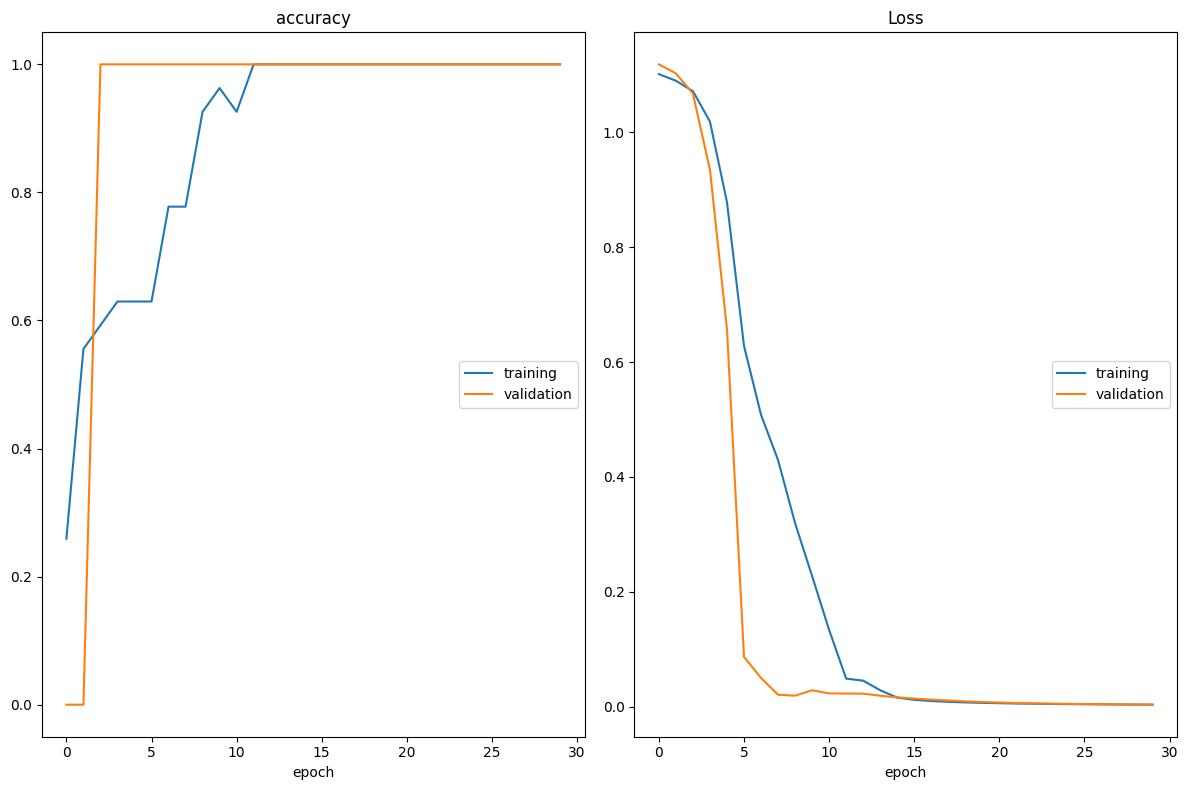

accuracy
	training         	 (min:    0.259, max:    1.000, cur:    1.000)
	validation       	 (min:    0.000, max:    1.000, cur:    1.000)
Loss
	training         	 (min:    0.003, max:    1.101, cur:    0.003)
	validation       	 (min:    0.003, max:    1.118, cur:    0.003)
4/4 [==============================] - 1s 171ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.0035 - val_accuracy: 1.0000


In [ ]:
history_1 = sequence_model.fit(X_train, y_train, epochs=30, batch_size=8, validation_data=(X_val, y_val), callbacks = [PlotLossesKeras()])

In [ ]:
save_model(sequence_model, '/content/sample_sequence.h5')

<ipython-input-42-9fba25e07114>:1: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(sequence_model, '/content/sample_sequence.h5')


In [ ]:
sequence_model = load_model('/content/sample_sequence.h5')

In [ ]:
predictions_sequence = sequence_model.predict(X_train)

1/1 [==============================] - 1s 1s/step


In [ ]:
predictions_sequence =np.argmax(predictions_sequence, axis=1)
predictions_sequence

array([1, 0, 0, 2, 2, 1, 0, 0, 1, 0, 1, 1, 2, 0, 0, 2, 0, 2, 2, 1, 2, 2,
       0, 1, 1, 1, 0])

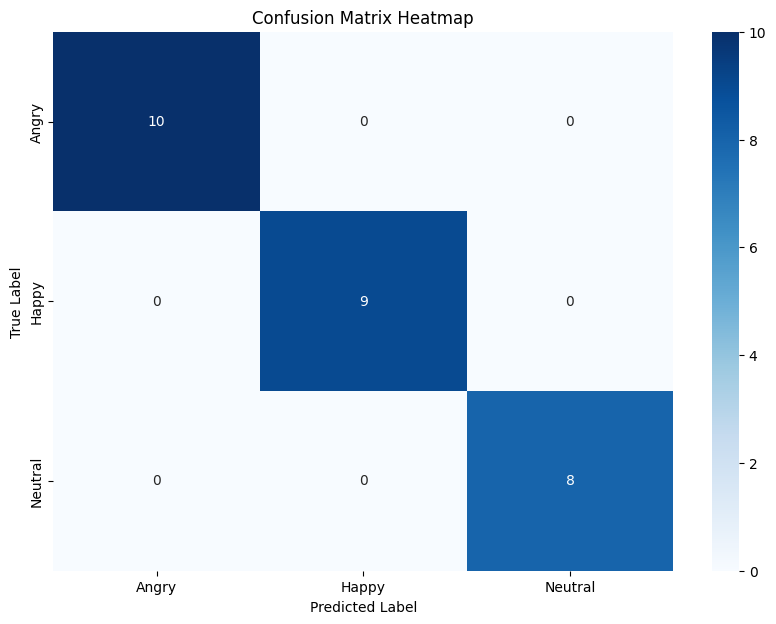

In [ ]:
conf_matrix = confusion_matrix(y_train, predictions_sequence)
class_names = label_encoder.classes_


plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.show()


# Testing custom input using LSTM



In [ ]:
def custom_string_prediction(string):
  X_custom = [string]
  X_custom_seq = tokenizer.texts_to_sequences(X_custom)
  X_custom_padded = pad_sequences(X_custom_seq, maxlen=max_sequence_length)
  y_custom_pred_prob = sequence_model.predict(X_custom_padded)
  y_custom_pred = np.argmax(y_custom_pred_prob, axis=1)
  return y_custom_pred

In [ ]:
X = 'I AM REALLY ANNOYED BY YOUR CONSTANT COMPLAINING AND YOU NEVER OFFER ANY SOLUTIONS WHICH IS VERY UNHELPFUL AND NEGATIVE'
print(custom_string_prediction(X))

1/1 [==============================] - 0s 20ms/step
[1]


# Pridicting the text from image

In [ ]:
predictions_sequence_image = []
for sentences in predictions.values():
  predictions_sequence_image.append(custom_string_prediction(sentences))
  print(custom_string_prediction(sentences))

1/1 [==============================] - 0s 19ms/step
[2]
1/1 [==============================] - 0s 29ms/step
[2]
1/1 [==============================] - 0s 19ms/step
[1]
1/1 [==============================] - 0s 21ms/step
[2]
1/1 [==============================] - 0s 23ms/step
[1]
1/1 [==============================] - 0s 20ms/step
[2]


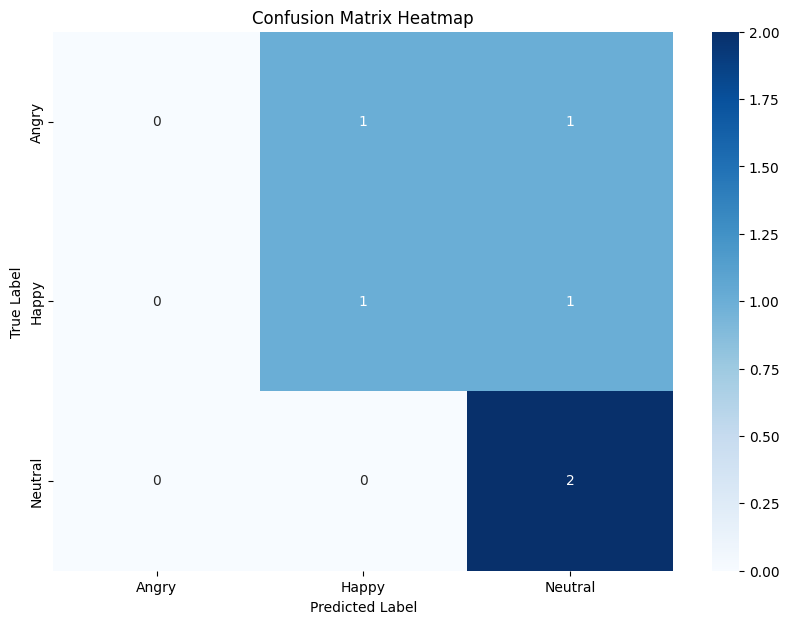

In [ ]:
conf_matrix = confusion_matrix(true_labels, predictions_sequence_image)
class_names = label_encoder.classes_


plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.show()

#Sentiment analysis using Naive Bayes

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
sentiment_dataset = pd.read_csv('/content/sentiment_analysis_dataset.csv')
X = sentiment_dataset['line'].values
y = sentiment_dataset['sentiment'].values

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [ ]:
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

MultinomialNB()

Accuracy: 1.0
Confusion Matrix:
[[8 0 0]
 [0 8 0]
 [0 0 8]]


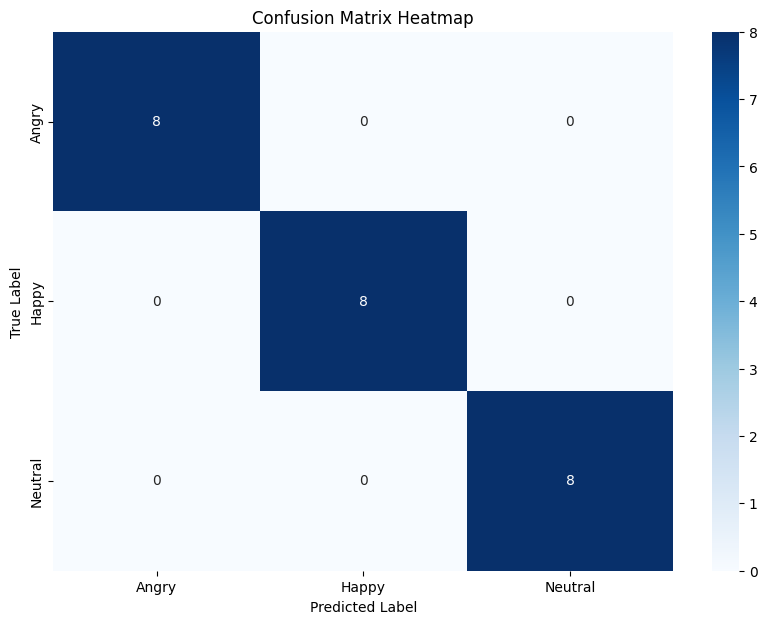

In [ ]:
y_pred = nb_model.predict(X_train_tfidf)

accuracy = accuracy_score(y_train, y_pred)
print(f'Accuracy: {accuracy}')

conf_matrix = confusion_matrix(y_train, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.show()

# Testing custom input using Naive Bayes

In [ ]:
def predict_emotion(text):
    text_tfidf = vectorizer.transform([text])
    prediction = nb_model.predict(text_tfidf)
    emotion = label_encoder.inverse_transform(prediction)
    return emotion[0]

In [ ]:
custom_text = "YOU MAKE ME WANT TO LIVE ANOTHER DAY I AM SO HAPPY THAT I FOUND YOU"
predicted_emotion = predict_emotion(custom_text)
print(f"Predicted Emotion: {predicted_emotion}")

Predicted Emotion: Happy


# Pridicting test from images

In [ ]:
prediction_naive_bayes = []
for sentences in predictions.values():
  prediction_naive_bayes.append(predict_emotion(sentences))
  print(predict_emotion(sentences))

Neutral
Happy
Happy
Angry
Happy
Neutral


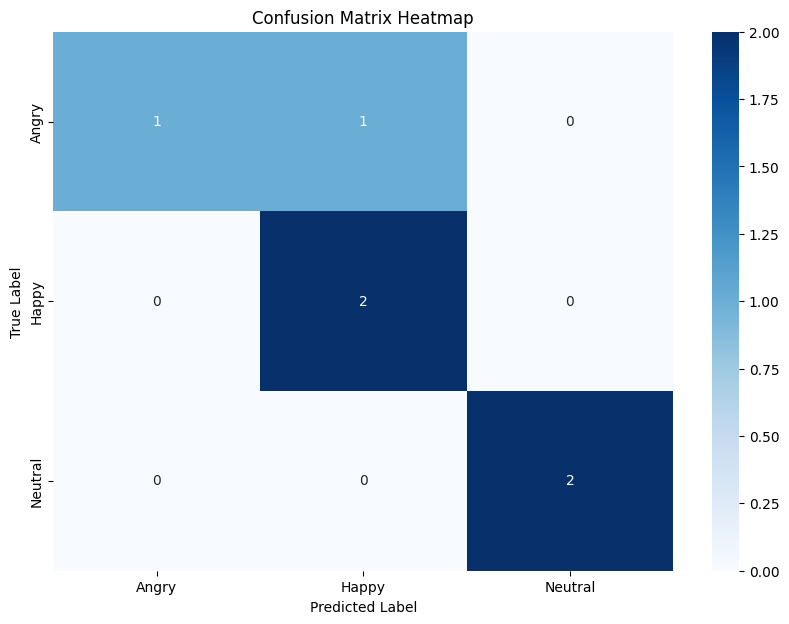

In [ ]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(prediction_naive_bayes)

conf_matrix = confusion_matrix(true_labels, y_encoded)
class_names = label_encoder.classes_


plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.show()

# CONCLUSION: Clearly, naive bayes outperforms the sequence deep learning model, this is due to very few datapoint in the dataset. Deep learning model would have easily outperform naive bayes had the dataset been bigger

# Self implimented naive bayes

In [ ]:
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk

nltk.download('stopwords')

# Load the dataset
df = pd.read_csv('/content/sentiment_analysis_dataset.csv')

# Preprocess the text
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    words = text.split()
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]
    return words

df['processed_text'] = df['line'].apply(preprocess_text)

# Calculate word frequencies
def get_word_frequency(X, y):
    word_dict = {'neutral': {}, 'happy': {}, 'angry': {}}
    class_frequency = {'neutral': 0, 'happy': 0, 'angry': 0}

    for i, words in enumerate(X):
        cls = y[i]
        class_frequency[cls] += 1
        for word in set(words):
            if word not in word_dict[cls]:
                word_dict[cls][word] = 0
            word_dict[cls][word] += 1

    return word_dict, class_frequency

word_frequency, class_frequency = get_word_frequency(df['processed_text'], df['label'])

# Compute probabilities
def prob_word_given_class(word, cls, word_frequency, class_frequency):
    if word in word_frequency[cls]:
        return (word_frequency[cls][word] + 1) / (class_frequency[cls] + len(word_frequency[cls]))
    else:
        return 1 / (class_frequency[cls] + len(word_frequency[cls]))

def prob_text_given_class(words, cls, word_frequency, class_frequency):
    prob = 1.0
    for word in words:
        prob *= prob_word_given_class(word, cls, word_frequency, class_frequency)
    return prob

def naive_bayes_classifier(words, word_frequency, class_frequency):
    classes = ['neutral', 'happy', 'angry']
    class_probs = {cls: class_frequency[cls] / sum(class_frequency.values()) for cls in classes}
    text_probs = {cls: prob_text_given_class(words, cls, word_frequency, class_frequency) for cls in classes}

    total_probs = {cls: class_probs[cls] * text_probs[cls] for cls in classes}
    predicted_class = max(total_probs, key=total_probs.get)

    return predicted_class

# Classify the test data
df['predicted_label'] = df['processed_text'].apply(lambda x: naive_bayes_classifier(x, word_frequency, class_frequency))

# Print the classification results
print(df[['line', 'label', 'predicted_label']])


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


KeyError: 'text'

In [ ]:
import re
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
df = pd.read_csv('/content/sentiment_analysis_dataset.csv')
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text
df['line'] = df['line'].apply(preprocess_text)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['line'], df['line'], test_size=0.2, random_state=42)


In [ ]:
def get_word_frequency(X, Y):
    word_dict = defaultdict(lambda: defaultdict(lambda: 0))
    num_emails = len(X)

    for i in range(num_emails):
        email = set(X[i].split())
        cls = Y[i]
        for word in email:
            word_dict[word][cls] += 1

    return word_dict

In [ ]:
word_frequency = get_word_frequency(X_train.values, y_train.values)
class_frequency = dict(y_train.value_counts())

In [ ]:

def prob_word_given_class(word, cls, word_frequency, class_frequency):
    amount_word_and_class = word_frequency[word][cls]
    p_word_given_class = (amount_word_and_class + 1) / (class_frequency[cls] + len(word_frequency))
    return p_word_given_class


In [ ]:
def prob_email_given_class(treated_email, cls, word_frequency, class_frequency):
    prob = 1
    for word in treated_email:
        if word in word_frequency.keys():
            prob *= prob_word_given_class(word, cls, word_frequency, class_frequency)
    return prob


In [ ]:
def naive_bayes(treated_email, word_frequency, class_frequency, return_likelihood=False):
    prob_email_given_happy = prob_email_given_class(treated_email, "happy", word_frequency, class_frequency)
    prob_email_given_angry = prob_email_given_class(treated_email, "angry", word_frequency, class_frequency)
    prob_email_given_neutral = prob_email_given_class(treated_email, "neutral", word_frequency, class_frequency)

    p_happy = class_frequency['happy'] / sum(class_frequency.values())
    p_angry = class_frequency['angry'] / sum(class_frequency.values())
    p_neutral = class_frequency['neutral'] / sum(class_frequency.values())

    happy_likelihood = p_happy * prob_email_given_happy
    angry_likelihood = p_angry * prob_email_given_angry
    neutral_likelihood = p_neutral * prob_email_given_neutral

    if return_likelihood:
        return (happy_likelihood, angry_likelihood, neutral_likelihood)
    else:
        likelihoods = {'happy': happy_likelihood, 'angry': angry_likelihood, 'neutral': neutral_likelihood}
        return max(likelihoods, key=likelihoods.get)

In [ ]:
def predict(X_test, word_frequency, class_frequency):
    predictions = []
    for text in X_test:
        treated_email = text.split()
        predictions.append(naive_bayes(treated_email, word_frequency, class_frequency))
    return predictions

In [ ]:
y_pred = predict(X_test.values, word_frequency, class_frequency)
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred, labels=['neutral', 'happy', 'angry'])

KeyError: 'happy'

In [ ]:

y_pred = predict(X_test.values, word_frequency, class_frequency)
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred, labels=['neutral', 'happy', 'angry'])

print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(cm)

# Test the classifier with a new text
new_text = "I am very happy today"
predicted_class = naive_bayes(new_text.split(), word_frequency, class_frequency)
print(f'The predicted class for "{new_text}" is {predicted_class}')


KeyError: 'text'